<a href="https://colab.research.google.com/github/Antosny/learning_pytorch_and_llm/blob/main/learning_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torchaudio
dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root=".",
    download=True
)

100%|██████████| 2.26G/2.26G [01:42<00:00, 23.7MB/s]


In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa

In [ ]:
# install torchcodec
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.9 MB/s eta 0:00:00


In [ ]:
from torchvision import datasets, transforms

transform = transforms.ToTensor()

mnist_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

mnist_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

fashion_train = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

fashion_test = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]
100%|██████████| 26.4M/26.4M [00:03<00:00, 7.88MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 187kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.8MB/s]


In [ ]:
import IPython
wav = dataset[12902][0].numpy()
n_mels=256
hop_length=100
sr=16000
l = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=n_mels, hop_length=hop_length)
IPython.display.Audio(librosa.feature.inverse.mel_to_audio(librosa.power_to_db(l), sr=16000, hop_length=hop_length,n_iter=32), rate=16000)

In [ ]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
# build an autoencoder based on reconsturction loss

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPAutoencoder(nn.Module):
    def __init__(self, n_mels: int, n_frames: int, z_dim: int = 1024, hidden_dims=(2048, 1024), dropout=0.1):
        super().__init__()
        self.n_mels = n_mels
        self.n_frames = n_frames
        in_dim = n_mels * n_frames

        # Encoder MLP
        enc_layers = []
        prev = in_dim
        for h in hidden_dims:
            enc_layers += [nn.Linear(prev, h), nn.GELU(), nn.Dropout(dropout)]
            prev = h
        self.encoder = nn.Sequential(*enc_layers)
        self.to_z = nn.Linear(prev, z_dim)

        # Decoder MLP
        dec_layers = []
        prev = z_dim
        for h in reversed(hidden_dims):
            dec_layers += [nn.Linear(prev, h), nn.GELU()]
            prev = h
        dec_layers += [nn.Linear(prev, in_dim)]  # linear output (good for standardized log-mel)
        self.decoder = nn.Sequential(*dec_layers)

    def encode(self, x):
        x = self._flatten(x)
        h = self.encoder(x)
        z = self.to_z(h)
        return z

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat.view(-1, self.n_mels, self.n_frames)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

    def _flatten(self, x):
        # Accept (B, M, T) or (B, 1, M, T)
        if x.dim() == 4:
            x = x.squeeze(1)
        assert x.dim() == 3, f"Expected (B,M,T) or (B,1,M,T), got {x.shape}"
        B, M, T = x.shape
        assert M == self.n_mels and T == self.n_frames, f"Shape mismatch: got {x.shape}, expected (*,{self.n_mels},{self.n_frames})"
        return x.reshape(B, -1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPMelVAE(nn.Module):
    def __init__(self, n_mels: int, n_frames: int, z_dim: int = 1024, hidden_dims=(2048, 1024), dropout=0.0):
        super().__init__()
        self.n_mels = n_mels
        self.n_frames = n_frames
        in_dim = n_mels * n_frames

        # Encoder MLP
        enc_layers = []
        prev = in_dim
        for h in hidden_dims:
            enc_layers += [nn.Linear(prev, h), nn.GELU(), nn.Dropout(dropout)]
            prev = h
        self.encoder = nn.Sequential(*enc_layers)
        self.fc_mu = nn.Linear(prev, z_dim)
        self.fc_logvar = nn.Linear(prev, z_dim)

        # Decoder MLP
        dec_layers = []
        prev = z_dim
        for h in reversed(hidden_dims):
            dec_layers += [nn.Linear(prev, h), nn.GELU()]
            prev = h
        dec_layers += [nn.Linear(prev, in_dim)]
        self.decoder = nn.Sequential(*dec_layers)

    def encode(self, x):
        x = self._flatten(x)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat.view(-1, self.n_mels, self.n_frames)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def loss_function(self, x, x_hat, mu, logvar):
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(x_hat, x, reduction='mean')
        # KL divergence
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss

    def _flatten(self, x):
        # Accept (B, M, T) or (B, 1, M, T)
        if x.dim() == 4:
            x = x.squeeze(1)
        assert x.dim() == 3, f"Expected (B,M,T) or (B,1,M,T), got {x.shape}"
        B, M, T = x.shape
        assert M == self.n_mels and T == self.n_frames, f"Shape mismatch: got {x.shape}, expected (*,{self.n_mels},{self.n_frames})"
        return x.reshape(B, -1)

In [ ]:
len(dataset)

105829

In [ ]:
import time
import random
start = time.time()
train = []
val = []
for i in range(len(dataset)):
    r = random.random()
    if r > 0.1:
      continue
    x = list(dataset[i])
    if len(x[0][0]) != 16000:
      continue
    n_mels=256
    hop_length=200
    l = torch.Tensor(librosa.power_to_db(librosa.feature.melspectrogram(y=x[0].numpy(), sr=sr, n_mels=n_mels, hop_length=hop_length)[0]))
    x.append(l)


    if r > 0.01:
      train.append(x)
    else:
      val.append(x)

print("time:", time.time() - start)

time: 159.46485567092896


In [ ]:
len(train)

NameError: name 'train' is not defined

In [ ]:
global_mean = torch.Tensor(np.array([x[-1].numpy() for x in train]).mean(axis=0))
global_std = torch.Tensor(np.array([x[-1].numpy() for x in train]).std(axis=0))

In [ ]:
# --- Improved Architecture: 2D Convolutional Autoencoder ---
class ConvAutoencoder(nn.Module):
    def __init__(self, n_mels: int, n_frames: int, z_dim: int = 256):
        super().__init__()
        self.n_mels = n_mels
        self.n_frames = n_frames

        # 1. Encoder (Downsampling)
        # We use strided convolutions to downsample spatial dims (Time/Freq)
        self.encoder_cnn = nn.Sequential(
            # Input: (B, 1, n_mels, n_frames)
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # -> (128, H/8, W/8)
            nn.BatchNorm2d(128),
            nn.GELU(),
        )

        # Calculate flattened size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_mels, n_frames)
            flat_shape = self.encoder_cnn(dummy).shape
            self.flat_dim = flat_shape[1] * flat_shape[2] * flat_shape[3]
            self.sh_c, self.sh_h, self.sh_w = flat_shape[1:]

        # Latent projection
        self.to_z = nn.Linear(self.flat_dim, z_dim)
        self.from_z = nn.Linear(z_dim, self.flat_dim)

        # 2. Decoder (Upsampling)
        self.decoder_cnn = nn.Sequential(
            # Input: (128, H/8, W/8)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def encode(self, x):
        # Ensure 4D input (B, 1, M, T)
        if x.dim() == 3: x = x.unsqueeze(1)

        h = self.encoder_cnn(x)
        #print(h.shape)
        h = h.view(h.size(0), -1) # Flatten
        #print(h.shape)
        z = self.to_z(h)
        return z

    def decode(self, z):
        h = self.from_z(z)
        h = h.view(h.size(0), self.sh_c, self.sh_h, self.sh_w) # Unflatten
        x_hat = self.decoder_cnn(h)

        # Resize to match exact original dimensions in case of rounding errors during pooling
        if x_hat.shape[2:] != (self.n_mels, self.n_frames):
             x_hat = F.interpolate(x_hat, size=(self.n_mels, self.n_frames), mode='bilinear', align_corners=False)

        return x_hat

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z



import torch
import torch.nn as nn

class Conv2dAutoencoder(nn.Module):
    """
    Spectrogram autoencoder.

    Input:  (B, M, T) or (B, 1, M, T)
    Output: x_hat (B, M, T), z (B, z_dim)

    Notes:
    - Uses strided convs to downsample (M, T).
    - Uses adaptive pooling so it works with odd sizes (e.g., 128x41) robustly.
    """
    def __init__(self, n_mels: int, n_frames: int, z_dim: int = 256, base_ch: int = 64):
        super().__init__()
        self.n_mels = n_mels
        self.n_frames = n_frames
        self.z_dim = z_dim

        # ----- Encoder: (B,1,M,T) -> (B,C,H,W) -----
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, base_ch, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.GELU(),

            nn.Conv2d(base_ch, base_ch * 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_ch * 2),
            nn.GELU(),

            nn.Conv2d(base_ch * 2, base_ch * 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_ch * 4),
            nn.GELU(),

            # nn.Conv2d(base_ch * 4, base_ch * 4, 3, stride=2, padding=1),
            # nn.BatchNorm2d(base_ch * 4),
            # nn.GELU(),
        )

        # Make the encoder output a fixed spatial size so the FC head is stable
        # (this avoids annoying off-by-one issues with odd frame counts).
        #self.enc_pool = nn.AdaptiveAvgPool2d((16, 16))  # (B, C, 4, 4)

        enc_out_dim = 90112 #(base_ch * 4) * 16 * 6
        self.to_z = nn.Sequential(
            nn.Linear(enc_out_dim, 512),
            nn.GELU(),
            nn.Linear(512, z_dim),
        )

        # ----- Decoder: z -> (B,1,M,T) -----
        # We'll project z back to a small feature map then upsample with transposed conv.
        self.from_z = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.GELU(),
            nn.Linear(512, (base_ch * 4) * 16 * 6),
            nn.GELU(),
        )

        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(base_ch * 4, base_ch * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(base_ch * 4),
            nn.GELU(),

            nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(base_ch * 2),
            nn.GELU(),

            nn.ConvTranspose2d(base_ch * 2, base_ch, 4, stride=2, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.GELU(),

            nn.ConvTranspose2d(base_ch, 1, 4, stride=2, padding=1),
            # output is linear (good for standardized log-mel)
        )

        # Final resize to exact (M, T) to guarantee shape match.
        # This makes the model robust to any small mismatch from stride/padding.
        self.out_resize = nn.Upsample(size=(n_mels, n_frames), mode="bilinear", align_corners=False)

    def encode(self, x):
        x = self._to_4d(x)              # (B,1,M,T)
        h = self.enc_conv(x)            # (B,C,*,*)
        #print(h.shape)
        #h = self.enc_pool(h)            # (B,C,4,4)
        #print(h.shape)
        h = h.flatten(1)                # (B,C*4*4)
        #print(h.shape)
        z = self.to_z(h)                # (B,z_dim)
        #print(z.shape)
        return z

    def decode(self, z):
        h = self.from_z(z)                              # (B,C*4*4)
        #print(h.shape)
        h = h.view(z.size(0), -1, 16, 6)                # (B,C,4,4)
        x_hat = self.dec_deconv(h)                     # (B,1,~M,~T)
        #x_hat = self.out_resize(x_hat)                 # (B,1,M,T)
        x_hat = F.interpolate(x_hat, size=(self.n_mels, self.n_frames),
                      mode='bilinear')  # or just crop
        return x_hat.squeeze(1)                        # (B,M,T)


    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

    def _to_4d(self, x):
        # Accept (B, M, T) or (B, 1, M, T) and return (B, 1, M, T)
        if x.dim() == 3:
            x = x.unsqueeze(1)
        elif x.dim() == 4:
            pass
        else:
            raise ValueError(f"Expected (B,M,T) or (B,1,M,T), got {x.shape}")
        B, C, M, T = x.shape
        if C != 1:
            raise ValueError(f"Expected channel=1, got {C}")
        if M != self.n_mels or T != self.n_frames:
            raise ValueError(f"Shape mismatch: got (M,T)=({M},{T}), expected ({self.n_mels},{self.n_frames})")
        return x


In [ ]:
def print_input_shape(module, input, output):
    print(f"Input shape to {module}: {input[0].shape}, output:{output.shape}")

In [ ]:
from torch.utils.data import DataLoader

def train_ae(model, train_ds, val_ds, device="cuda" if torch.cuda.is_available() else "cpu",
             lr=1e-4, batch_size=64, epochs=10, grad_clip=1.0, norm=True):
    model.to(device)
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    model.train()
    for ep in range(1, epochs + 1):
        model.train()
        total = 0.0
        for x in loader:
            #print('hey', ep)
            # x can be (B,M,T) or dict/tuple; adjust if your dataset returns more
            if norm:
              x = (x[-1] - global_mean) / global_std
            else:
              x = x[0]
            if isinstance(x, (tuple, list)):
                x = x[0]
            x = x.to(device)

            x_hat, _ = model(x)
            loss = F.mse_loss(x_hat.squeeze(1) if x_hat.dim()==4 else x_hat, x.squeeze(1) if x.dim()==4 else x)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                    # Validation

            opt.step()

            total += loss.item()
        # Validation
        if ep % 5 == 0:
          model.eval()
          val_loss = 0.0
          start = time.time()
          with torch.no_grad():
              for v in val_ds:
                  if norm:
                    v_norm = (v[-1] - global_mean) / global_std
                  else:
                    v_norm = v[0]
                  v_norm = v_norm.unsqueeze(0).to(device)  # ← ADD BATCH DIM HERE
                  v_hat, _ = model(v_norm)
                  val_loss += F.mse_loss(v_hat.squeeze(1) if v_hat.dim()==4 else v_hat, v_norm.to(device)).item()
          print("val time:", time.time() - start)
          val_loss /= len(val_ds)

          print(f"epoch {ep:02d} | mse {total/len(loader):.6f} | val {val_loss:.6f}")
        else:
          print(f"epoch {ep:02d} | mse {total/len(loader):.6f}")

    return model


In [ ]:
global_mean

tensor([[-41.7839, -41.1611, -41.0497,  ..., -38.0828, -38.1345, -38.8041],
        [-40.7842, -40.1591, -40.0859,  ..., -37.2553, -37.2255, -37.8385],
        [-40.9328, -40.3376, -40.2495,  ..., -37.5613, -37.5569, -38.1389],
        ...,
        [-54.2182, -54.0633, -54.0248,  ..., -53.7312, -53.5577, -53.5942],
        [-54.4166, -54.3129, -54.3108,  ..., -53.9054, -53.7021, -53.7016],
        [-54.5502, -54.4831, -54.5107,  ..., -54.0162, -53.7876, -53.7622]])

In [ ]:
ae = MLPAutoencoder(n_mels=n_mels, n_frames=81, z_dim=256, dropout=0., hidden_dims=(2048, 1024))
#conv_ae = Conv2dAutoencoder(n_mels=n_mels, n_frames=81)
vae = MLPMelVAE(n_mels=n_mels, n_frames=81, z_dim=256, dropout=0., hidden_dims=(2048, 1024))
conv_ae = Conv2dAutoencoder(n_mels=n_mels, n_frames=81)
conv_ae2 = ConvAutoencoder(n_mels=n_mels, n_frames=81)

In [ ]:
conv_minst = ConvAutoencoder(n_mels=28, n_frames=28)

In [ ]:
train_ae(conv_minst, mnist_train, mnist_train, batch_size=1024, lr=1e-3, epochs=3, norm=False)

epoch 01 | mse 0.029875
epoch 02 | mse 0.012558
epoch 03 | mse 0.008804


ConvAutoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
  )
  (to_z): Linear(in_features=2048, out_features=256, bias=True)
  (from_z): Linear(in_features=256, out_features=2048, bias=True)
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
# Register hooks for all Conv2d layers
for layer in conv_ae.enc_conv:
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(print_input_shape)

# Register hooks for all Conv2d layers
for layer in conv_ae2.encoder_cnn:
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(print_input_shape)

In [ ]:
import time
def train_vae(model, train_ds, val_ds, device="cuda" if torch.cuda.is_available() else "cpu",
              lr=1e-4, batch_size=64, epochs=10, grad_clip=1.0, beta=1.0, norm=True):
    """Training function for VAE models with β-VAE loss."""
    model.to(device)
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        model.train()
        total_loss, total_recon, total_kl = 0.0, 0.0, 0.0
        t = 0
        t_total = time.time()
        for x in loader:
            #start = time.time()
            if norm:
                x = (x[-1] - global_mean) / global_std
            else:
                x = x[0]
            if isinstance(x, (tuple, list)):
                x = x[0]
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            loss, recon_loss, kl_loss = model.loss_function(x, x_hat, mu, logvar, beta=beta)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            #load = time.time()
            #t += load - start
        print(t, time.time() - t_total)
        n_batches = len(loader)
        if ep % 5 == 0:
            model.eval()
            val_loss = 0.0
            val_recon = 0.
            with torch.no_grad():
                for v in val_ds:
                    if norm:
                        v_norm = (v[-1] - global_mean) / global_std
                    else:
                        v_norm = v[0]
                    v_norm = v_norm.unsqueeze(0).to(device)
                    v_hat, mu, logvar = model(v_norm)
                    loss, recon, _ = model.loss_function(v_norm, v_hat, mu, logvar, beta=beta)
                    val_loss += loss.item()
                    val_recon += recon.item()
            val_loss /= len(val_ds)
            val_recon /= len(val_ds)
            print(f"epoch {ep:02d} | loss {total_loss/n_batches:.6f} | recon {total_recon/n_batches:.6f} | kl {total_kl/n_batches:.6f} | val {val_loss:.6f}, recon {val_recon:.6f}")
        else:
            print(f"epoch {ep:02d} | loss {total_loss/n_batches:.6f} | recon {total_recon/n_batches:.6f} | kl {total_kl/n_batches:.6f}")

    return model

In [ ]:
# --- ConvVAE: Variational Autoencoder based on ConvAutoencoder ---
class ConvVAE(nn.Module):
    def __init__(self, n_mels: int, n_frames: int, z_dim: int = 256):
        super().__init__()
        self.n_mels = n_mels
        self.n_frames = n_frames

        # Encoder (same as ConvAutoencoder)
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
        )

        # Calculate flattened size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_mels, n_frames)
            flat_shape = self.encoder_cnn(dummy).shape
            self.flat_dim = flat_shape[1] * flat_shape[2] * flat_shape[3]
            self.sh_c, self.sh_h, self.sh_w = flat_shape[1:]

        # VAE: separate heads for mu and logvar
        self.fc_mu = nn.Linear(self.flat_dim, z_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, z_dim)
        self.from_z = nn.Linear(z_dim, self.flat_dim)

        # Decoder (same as ConvAutoencoder)
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def encode(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        h = self.encoder_cnn(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.from_z(z)
        h = h.view(h.size(0), self.sh_c, self.sh_h, self.sh_w)
        x_hat = self.decoder_cnn(h)
        if x_hat.shape[2:] != (self.n_mels, self.n_frames):
            #print(x_hat.shape)
            x_hat = F.interpolate(x_hat, size=(self.n_mels, self.n_frames), mode='bilinear', align_corners=False)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def loss_function(self, x, x_hat, mu, logvar, beta=1.0):
        """β-VAE loss: reconstruction + β * KL divergence"""
        # Ensure shapes match for MSE
        if x.dim() == 3:
            x = x.unsqueeze(1)
        recon_loss = F.mse_loss(x_hat, x, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + beta * kl_loss, recon_loss, kl_loss

In [ ]:
conv_minst_vae = ConvVAE(n_mels=28, n_frames=28, z_dim=32)

In [ ]:
def sample(vae, dim=256):
  vae.eval()
  with torch.no_grad():
      # Sample from standard normal (prior)
      z = torch.randn(1, dim).to('cuda')  # z_dim=256

      # Decode to get mel spectrogram
      generated = vae.decode(z)

      # # Denormalize
      # generated = generated.squeeze() * global_std.to('cuda') + global_mean.to('cuda')

      # # Convert to audio
      # audio = librosa.feature.inverse.mel_to_audio(
      #     librosa.db_to_power(generated.cpu().numpy()),
      #     sr=16000, hop_length=hop_length, n_iter=20
      # )
      # display(IPython.display.Audio(audio, rate=16000))
      return generated

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Access the raw data directly (uint8 tensors)
#    Shape is (60000, 28, 28)
data = mnist_train.data
targets = mnist_train.targets

# 2. Pre-process manually once
#    Convert to Float, Normalize to [0, 1], Add Channel Dim
data = data.float() / 255.0
data = data.unsqueeze(1)  # Shape becomes (60000, 1, 28, 28)

# 3. Create a TensorDataset
#    This is pure memory indexing; 0 overhead.
fast_mnist = TensorDataset(data, targets)

# 4. Optional: Move ENTIRE dataset to GPU (If you have VRAM)
#    This makes the DataLoader instant because there is no CPU->GPU copy during the loop.
#    MNIST is only ~200MB, so it fits easily on any GPU.
if torch.cuda.is_available():
    data = data.to('cuda')
    targets = targets.to('cuda')
    fast_mnist = TensorDataset(data, targets)

# 5. Create Loader
#    Use num_workers=0 because the data is already on the device!
loader = DataLoader(fast_mnist, batch_size=2048, shuffle=True, drop_last=True, num_workers=0)

print("Starting loop...")
start = time.time()
# This loop should now be near-instant
for x, y in loader:
    pass
print("Done.", time.time() - start)

Starting loop...
Done. 0.9446878433227539


In [ ]:
loader = DataLoader(mnist_train, batch_size=2048, shuffle=True, drop_last=True, num_workers=0)
for x in loader:
  continue

In [ ]:
train_vae(conv_minst_vae, mnist_train, mnist_train, batch_size=8192, lr=1e-3, epochs=10, norm=False, beta=0.1)

0 8.340085744857788
epoch 01 | loss 0.067902 | recon 0.056839 | kl 0.110632


KeyboardInterrupt: 

In [ ]:
x = sample(conv_minst_vae)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

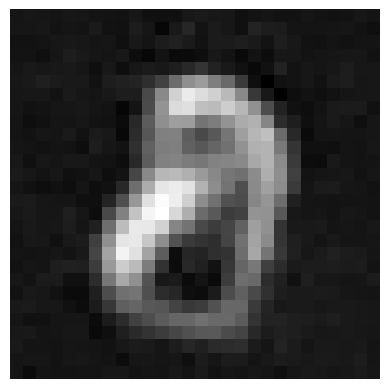

In [ ]:
from matplotlib import pyplot as plt
x = sample(conv_minst_vae)[0][0].cpu()
plt.imshow(x, cmap="gray")
plt.axis("off")

In [ ]:
# Train ConvVAE
conv_vae = ConvVAE(n_mels=n_mels, n_frames=81, z_dim=256)
train_vae(conv_vae, train, val, batch_size=128, lr=1e-3, epochs=30, beta=0.01)

epoch 01 | loss 4552.731865 | recon 0.547785 | kl 455218.409357
epoch 02 | loss 0.226154 | recon 0.193926 | kl 3.222742
epoch 03 | loss 0.170921 | recon 0.147939 | kl 2.298281
epoch 04 | loss 0.147325 | recon 0.127314 | kl 2.001075
epoch 05 | loss 0.136813 | recon 0.117231 | kl 1.958229 | val 0.126540, recon 0.108004
epoch 06 | loss 0.123406 | recon 0.104896 | kl 1.850966
epoch 07 | loss 0.115168 | recon 0.096673 | kl 1.849431
epoch 08 | loss 0.108262 | recon 0.089783 | kl 1.847973
epoch 09 | loss 0.103852 | recon 0.085561 | kl 1.829180
epoch 10 | loss 0.100469 | recon 0.082084 | kl 1.838517 | val 0.099882, recon 0.080979
epoch 11 | loss 0.096399 | recon 0.078059 | kl 1.833960
epoch 12 | loss 0.092358 | recon 0.074092 | kl 1.826656
epoch 13 | loss 0.091328 | recon 0.073144 | kl 1.818454
epoch 14 | loss 0.088257 | recon 0.070073 | kl 1.818395
epoch 15 | loss 0.087024 | recon 0.068938 | kl 1.808615 | val 0.091777, recon 0.074093
epoch 16 | loss 0.085490 | recon 0.067470 | kl 1.802062
epo

ConvVAE(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
  )
  (fc_mu): Linear(in_features=45056, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=45056, out_features=256, bias=True)
  (from_z): Linear(in_features=256, out_features=45056, bias=True)
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64

In [ ]:
def sample(vae, dim=256):
  vae.eval()
  with torch.no_grad():
      # Sample from standard normal (prior)
      z = torch.randn(1, dim).to('cuda')  # z_dim=256

      # Decode to get mel spectrogram
      generated = vae.decode(z)

      # Denormalize
      generated = generated.squeeze() * global_std.to('cuda') + global_mean.to('cuda')

      # Convert to audio
      audio = librosa.feature.inverse.mel_to_audio(
          librosa.db_to_power(generated.cpu().numpy()),
          sr=16000, hop_length=hop_length, n_iter=20
      )
      display(IPython.display.Audio(audio, rate=16000))
      return audio

In [ ]:
p_ = sample(conv_vae)

In [ ]:
datapoint = val[40][-1]
conv_ae2.eval()
with torch.no_grad():
    pred = (conv_ae2(((datapoint.unsqueeze(0) - global_mean) / global_std).to('cuda'))[0]) * global_std.to('cuda') + global_mean.to('cuda')
    pred = pred[0]

display(IPython.display.Audio(librosa.feature.inverse.mel_to_audio(librosa.db_to_power(pred.cpu().numpy()), sr=16000, hop_length=hop_length,n_iter=20), rate=16000))
display(IPython.display.Audio(librosa.feature.inverse.mel_to_audio(librosa.db_to_power(datapoint.numpy()), sr=16000, hop_length=hop_length,n_iter=20), rate=16000))

In [ ]:
datapoint[datapoint < 1] = 0

In [ ]:
display(IPython.display.Audio(librosa.feature.inverse.mel_to_audio((np.clip(datapoint, a_max=222222, a_min=0.01).numpy()), sr=16000, hop_length=hop_length,n_iter=122), rate=16000))

In [ ]:
np.clip(datapoint, a_max=222222, a_min=0.01).numpy()

array([[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]], dtype=float32)

In [ ]:
abs((datapoint)[4] - pred[0][4].cpu()).mean()

tensor(0.1410)

In [ ]:
abs(((datapoint - global_mean) / (global_std))[4] - pred[0][4].cpu()).mean()

tensor(0.0451)

In [ ]:
pred[0][0]

tensor([ 5.4259e-01,  1.3351e+00, -1.0101e-01, -3.6518e-01, -5.5245e-02,
         4.6690e-01,  3.2590e-01,  2.8448e-01, -7.7902e-01,  2.7916e-02,
         5.0954e-01,  2.2226e+00, -1.4417e+00, -2.0014e-01,  3.2986e-01,
         8.3470e-01,  1.4909e-01,  2.0829e-01,  1.4472e-01,  4.5242e-02,
         3.0281e-01,  1.2284e-01,  4.2807e-01,  3.9069e-01,  1.1656e-01,
         6.5957e-02,  9.6915e-02, -1.7124e-02,  5.4001e-02, -3.1798e-02,
        -2.0855e-01,  2.8509e-01,  1.8397e-01,  1.3318e-01,  1.2497e-01,
         5.2033e-01, -5.0964e-02, -3.0775e-01, -4.7542e-01, -4.1529e-01,
         1.2615e-01,  2.7682e-01,  1.2162e-02,  5.8049e-02,  7.1213e-04,
         3.8166e-02,  2.3552e-01,  1.4742e-01,  2.1852e-01,  1.0884e-01,
         2.2204e-01,  7.8715e-02,  5.8331e-02,  2.9885e-01,  7.3028e-02,
        -6.2089e-02, -1.2322e-01,  8.6524e-02, -1.5784e-02,  2.2407e-01,
        -7.4599e-03, -5.4074e-01,  7.4698e-01,  2.4018e-01, -1.9466e-01,
         4.7200e-01,  2.0179e-01, -1.0221e-02,  1.6

In [ ]:
datapoint[100]

tensor([1.2046e-08, 2.2559e-08, 5.8498e-08, 1.1449e-07, 1.4955e-07, 1.4393e-07,
        1.0444e-07, 9.3092e-08, 1.5559e-07, 2.3714e-07, 2.6156e-07, 2.0451e-07,
        1.5988e-07, 2.3508e-07, 3.8033e-07, 4.5795e-07, 3.8124e-07, 2.0893e-07,
        7.0962e-08, 2.4959e-08, 3.8384e-08, 8.1293e-08, 1.2121e-07, 1.3588e-07,
        1.2219e-07, 9.3380e-08, 6.7186e-08, 4.6443e-08, 2.1218e-08, 4.0594e-08,
        1.4713e-04, 4.4808e-03, 2.0347e-02, 5.0174e-02, 8.5604e-02, 9.9949e-02,
        8.8984e-02, 7.1805e-02, 7.0368e-02, 7.3491e-02, 6.2007e-02, 3.6626e-02,
        1.2867e-02, 4.1878e-03, 3.5657e-03, 3.4464e-03, 3.3517e-03, 2.5458e-03,
        1.1440e-03, 2.8642e-04, 6.7297e-05, 1.2967e-04, 3.1269e-04, 5.8897e-04,
        8.0166e-04, 9.6279e-04, 2.1408e-03, 3.8084e-03, 7.8984e-03, 6.6229e-02,
        2.8555e-01, 6.6074e-01, 9.8658e-01, 1.0263e+00, 7.5182e-01, 3.7643e-01,
        1.2349e-01, 3.0291e-02, 9.5329e-03, 4.4466e-03, 1.8100e-03, 7.4654e-04,
        8.1770e-04, 1.3304e-03, 1.5844e-